# Proyecto entrega 1

### Integrantes
* Santiago Gomez
* Sebastian Martinez
* Johan Suarez

### Grupo
36

## Carga de datos y descarga de librerias

Intsalación de spaCY y su diccipnario small en español.

In [131]:
# %pip install -U "spacy>=3.8,<3.9"
# %pip install "./es_core_news_sm-3.8.0-py3-none-any.whl" 

Este es el paso inicial para el proyecto, dado que acá importamos todas las librerías que se van a utilizar dentro del mismo, además de cargar algunas variables que serán de suma importancia para el desarrollo de este.
* vectorizer = Convierte los documentos en vectores usando la técnica TF-IDF.
* dfOriginal = Es él data frame resultante de realizar la lectura de los datos del xlsx.
* targetNames = Son los nombres de los valores únicos de la columna de labels.

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


vectorizer = TfidfVectorizer()
nlp = spacy.load("es_core_news_sm")
dfOriginal = pd.read_excel('Datos_proyecto.xlsx')
dfOriginal.info()
targetNames = dfOriginal['labels'].unique()
print("Categorías encontradas:", targetNames)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB
Categorías encontradas: [4 3 1]


## Exploración del texto

Principalmente, observemos el formato inicial del dataset, con especial énfasis en la columna de textos. Si observa el resultado del .info() hecho en el bloque pasado, observó que la columna de textos es un objeto, por lo que la convertiremos en string para el uso correcto de sus datos.

In [133]:
targetNames =  {1:'ODS 1',3:'ODS 3',4:'ODS 4'}
dfOriginal.head()
df = dfOriginal.copy()
df['textos'] = df['textos'].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


## Exploracion del dataset

### Longitud

Como primer análisis para nuestro dataset decidimos observar la cantidad de palabras de cada uno de nuestros datos, esto con el fin de entender mejor la longitud y variabilidad de los textos.
* Conteo: indica el número total de caracteres de cada texto.
* Max: registra la longitud de la palabra más larga encontrada en el texto.
* Min: registra la longitud de la palabra más corta en el texto.


In [134]:
def columnasConteo(df : pd.DataFrame):
    df['Conteo'] = [len(x) for x in df['textos']]
    df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['textos']]
    df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['textos']]
columnasConteo(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"Además, la formación de especialistas en medic...",3,659,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1
4,Este grupo se centró en las personas que padec...,3,608,14,0


Veamos ahora los máximos, mínimos y el promedio de la longitud de los textos del dataset.
* Máximo: el texto con mayor cantidad de caracteres.
* Mínimo: el texto con menor cantidad de caracteres.
* Promedio: la longitud promedio de los textos en el dataset.

In [135]:
def longitud(df: pd.DataFrame):
    maximo = df['Conteo'].max()
    minimo = df['Conteo'].min()
    promedio = int(df['Conteo'].mean())
    print(f'El maximo de longitud es: {maximo}')
    print(f'El minimo de longitud es: {minimo}')
    print(f'El promedio de longitud es: {promedio:.2f}')
    return maximo, minimo, promedio

Luego de calcular los valores de máximo, mínimo y promedio de la longitud de los textos, realizamos una visualización con un gráfico de barras. En este gráfico se muestran los tres valores principales:
* Máximo en color rojo.
* Mínimo en color verde.
* Promedio en color azul.

El maximo de longitud es: 1492
El minimo de longitud es: 303
El promedio de longitud es: 683.00


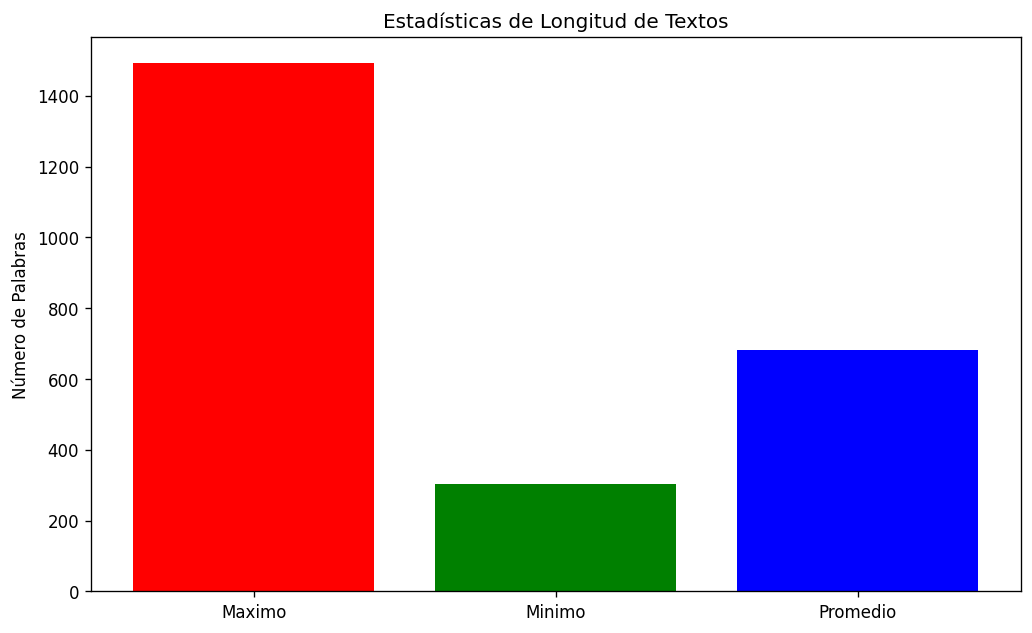

In [136]:
maximo, minimo, promedio = longitud(df)
plt.figure(figsize=(10,6))
plt.bar(['Maximo', 'Minimo', 'Promedio'], [maximo, minimo, promedio], color=['red', 'green', 'blue'])
plt.title('Estadísticas de Longitud de Textos')
plt.ylabel('Número de Palabras')
plt.show()


### Distribucion de la longitud

Posteriormente analizamos la distribución completa de esas longitudes en el dataset. Para ello utilizamos un histograma, donde en el eje X se representa la longitud de los textos y en el eje Y la frecuencia con que aparecen. Este gráfico nos permite ver de manera clara cómo se concentran la mayoría de los textos: si hay una tendencia hacia textos cortos o largos, y si existen valores atípicos con longitudes muy diferentes al resto.


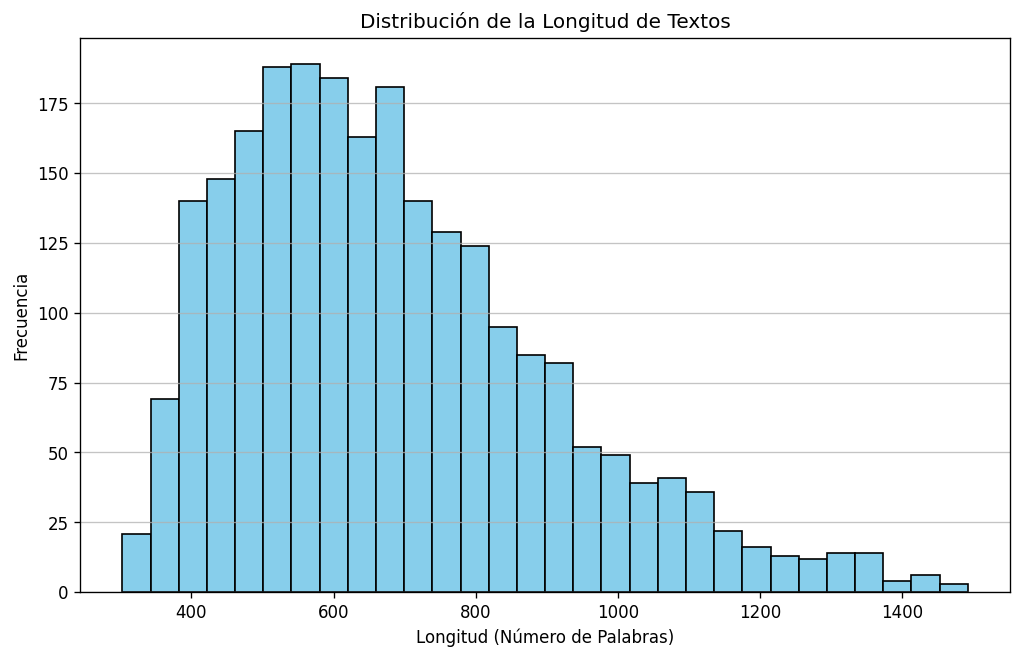

In [137]:

plt.figure(figsize=(10,6))
plt.hist(df['Conteo'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de Textos')
plt.xlabel('Longitud (Número de Palabras)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

Finalmente, para complementar el análisis de la longitud de los textos, realizamos un boxplot. Este tipo de gráfico resume la distribución mostrando la mediana, los cuartiles y posibles valores atípicos. En el eje X se representa el número de palabras por texto, lo que nos permite identificar rápidamente:
* El rango en el que se encuentran la mayoría de los textos.
* La posición de la mediana respecto a los extremos.
* Si existen outliers.

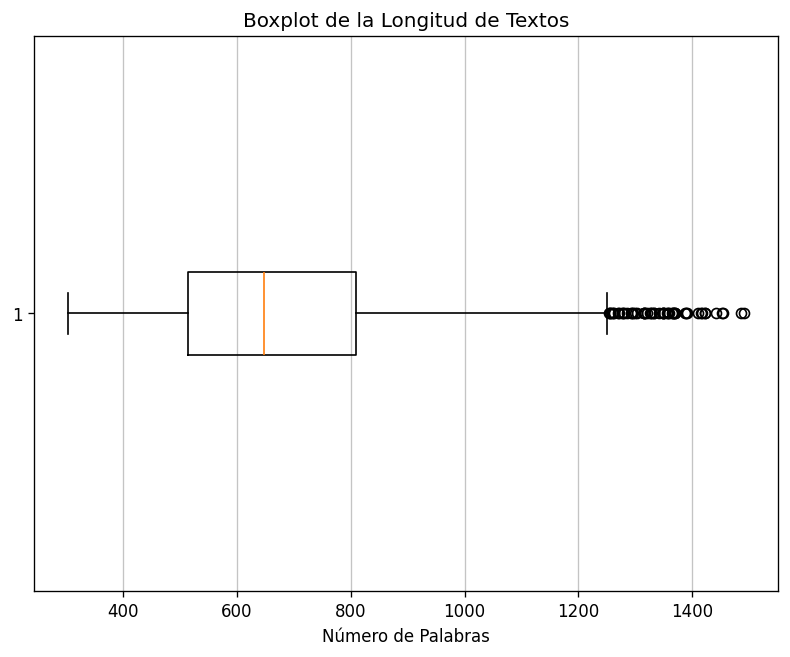

In [138]:
#Boxplot
plt.figure(figsize=(8,6))
plt.boxplot(df['Conteo'], vert=False)
plt.title('Boxplot de la Longitud de Textos')
plt.xlabel('Número de Palabras')
plt.grid(axis='x', alpha=0.75)
plt.show()

### Presencia de catracteres especiales

Después de analizar las longitudes de los textos, procedimos a revisar la presencia de signos de puntuación y caracteres especiales dentro del dataset. Para ello se identificaron los distintos simbolos y se calculó la cantidad de textos que los contenian.Este análisis permitió estimar qué tan frecuente es la presencia de este tipo de símbolos y entender la necesidad de aplicar procesos de limpieza.

In [139]:
def especiales(df : pd.DataFrame):
    signos = r"(?:[!¡¿?;:'\"]|\.{3})"
    signosPresentes = df['textos'].str.contains(signos).sum()
    print(f'La cantidad de textos con signos de puntuación es: {signosPresentes}')
    print(f'El porcentaje de textos con signos de puntuación es: {signosPresentes/len(df)*100:.2f}%')
    especiales = r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])"
    especialesPresentes = df['textos'].str.contains(especiales).sum()
    print(f'La cantidad de textos con caracteres especiales es: {especialesPresentes}')
    print(f'El porcentaje de textos con caracteres especiales es: {especialesPresentes/len(df)*100:.2f}%')
    return signosPresentes, especialesPresentes


La cantidad de textos con signos de puntuación es: 596
El porcentaje de textos con signos de puntuación es: 24.59%
La cantidad de textos con caracteres especiales es: 1562
El porcentaje de textos con caracteres especiales es: 64.44%


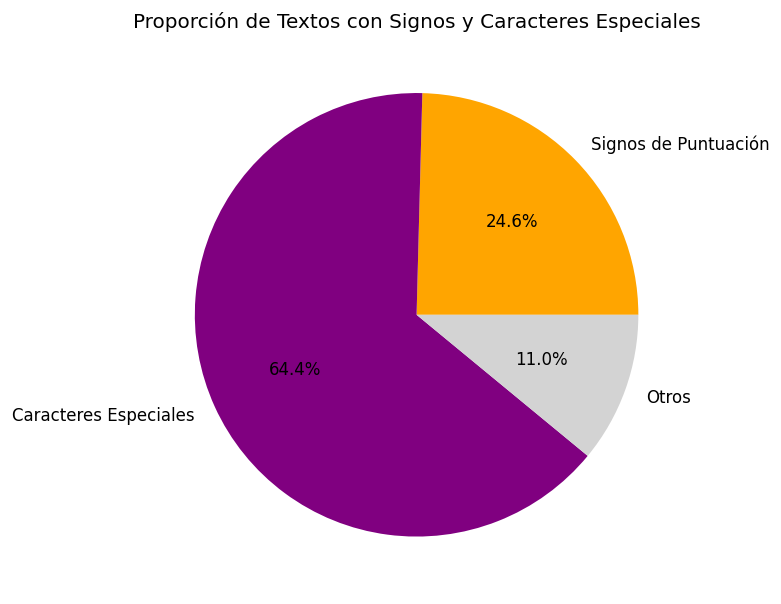

In [140]:
#Distribucion especiales
size = df['textos'].size
signosPresentes, especialesPresentes = especiales(df)
plt.figure(figsize=(8,6))
plt.pie([signosPresentes, especialesPresentes, size - signosPresentes - especialesPresentes], labels=['Signos de Puntuación', 'Caracteres Especiales', 'Otros'], autopct='%1.1f%%', colors=['orange', 'purple', 'lightgray'])
plt.title('Proporción de Textos con Signos y Caracteres Especiales')
plt.show()


### Distribucion de labels

Luego de revisar las características generales de los textos, se analizó la distribución de las categorías en el dataset. Para ello se contó la cantidad de registros pertenecientes a cada etiqueta y se organizaron según el nombre de la clase correspondiente para posteriormente plotear un gráfico con dicha información.

,conteo
ODS 1,505
ODS 3,894
ODS 4,1025


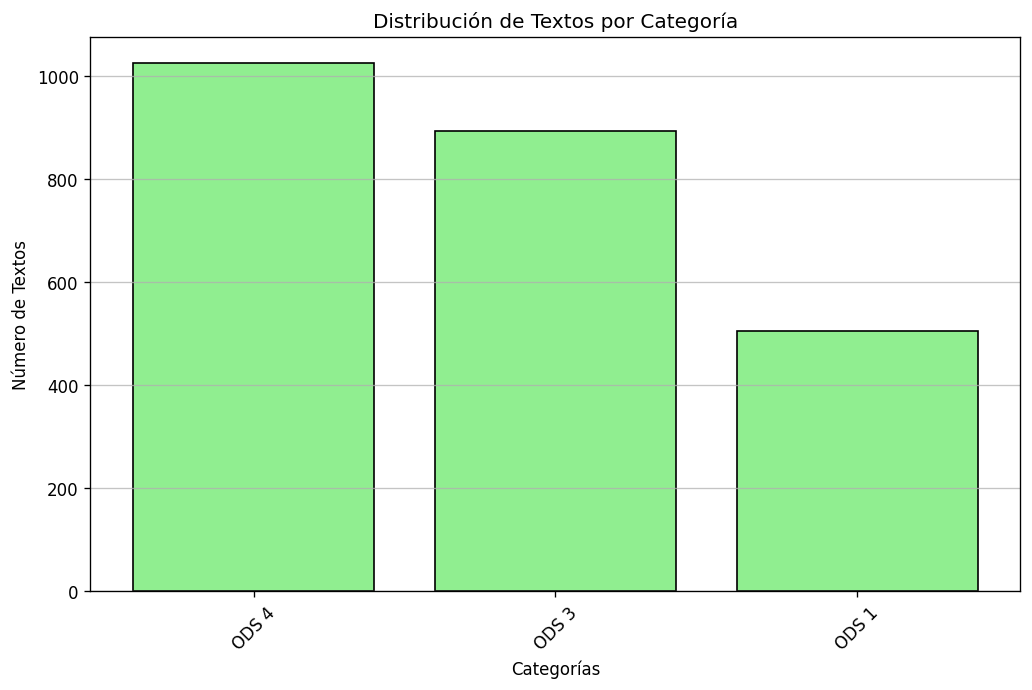

In [141]:
tiposComentario = df['labels'].value_counts().sort_index()
tiposComentario.index = [targetNames[i] for i in tiposComentario.index]
display(tiposComentario.to_frame('conteo'))

labelContador = df['labels'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(labelContador.index.map(targetNames), labelContador.values, color='lightgreen', edgecolor='black')
plt.title('Distribución de Textos por Categoría')
plt.xlabel('Categorías')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


Con el fin de comparar la longitud de los textos entre las distintas categorías, se construyó un boxplot agrupado por etiqueta. En este gráfico se puede observar la distribución de la cantidad de palabras para cada categoría, lo que permite identificar diferencias en la extensión de los textos según la clase, así como la presencia de valores atípicos.

<Figure size 1200x720 with 0 Axes>

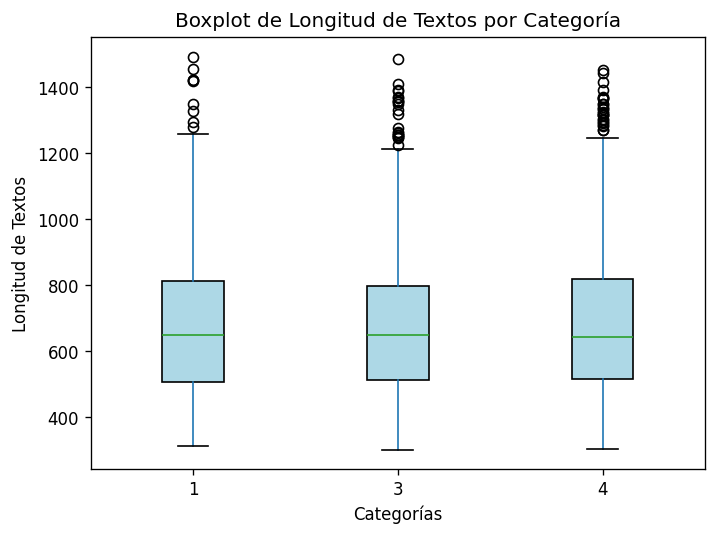

In [142]:
#Boxplot por categoria
plt.figure(figsize=(10,6))
df.boxplot(column='Conteo', by='labels', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Longitud de Textos por Categoría')
plt.suptitle('')  
plt.xlabel('Categorías')
plt.ylabel('Longitud de Textos')
plt.show()

### Limpieza

Procedemos a poner todo el dataset en un único formato, con el fin de evitar errores de entendimiento por diferencias entre mayusculas y minusculas.

In [143]:
def todoAmin(df: pd.DataFrame):
    df['textos'] = df['textos'].str.lower()
todoAmin(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"además, la formación de especialistas en medic...",3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


Seguido de la unificación a un solo formato, se realizó un proceso de limpieza de los textos con el objetivo de eliminar elementos que pudieran introducir ruido en el modelo. En este paso se retiraron enlaces web, signos de puntuación y caracteres especiales que no aportan información relevante, además de normalizar los espacios en blanco para que los textos quedaran más uniformes.

In [144]:
def limpiza(df: pd.DataFrame):
    df['textos'] = df['textos'].str.replace(r"http[s]?://[^\s)]+", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[!¡¿?;:'\".,]|\.{3})", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"\s+", ' ', regex=True).str.strip()
limpiza(df)
df.head()


,textos,labels,Conteo,Max,Min
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1
2,además la formación de especialistas en medici...,3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


### Duplicados y Nulos

Como parte de la revisión de calidad de los datos, se aplicó un análisis para detectar valores nulos, duplicados y columnas constantes en el dataset. Primero se contó cuántos valores faltantes había en cada columna, luego se identificaron las filas completamente duplicadas y, finalmente, se verificó si existían columnas con un único valor en todos sus registros.

In [145]:
#Codigo dado en el notebook de la clase
def verNulosYDuplicados(df: pd.DataFrame):
    print("Valores nulos por columna:")
    display(df.isnull().sum())
    print("\nDuplicados (filas completas):", df.duplicated().sum())
    const_cols = [c for c in df.columns if df[c].nunique() == 1]
    print("Columnas constantes:", const_cols if const_cols else "Ninguna")
verNulosYDuplicados(df)


Valores nulos por columna:


textos    0
labels    0
Conteo    0
Max       0
Min       0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


### Tokenización

Una vez que los textos estuvieron limpios, se procedió a realizar la tokenización, es decir, dividir cada opinión en una lista de palabras individuales.

In [146]:
def tokenizacion(df: pd.DataFrame):
    columnaTokens = []
    for opinion in df['textos']:
        columnaTokens.append(opinion.split())
    df['tokens'] = columnaTokens
    return df
doc = tokenizacion(df)   
df.head()

,textos,labels,Conteo,Max,Min,tokens
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q..."


### Eliminación de tockens innecesarios, articulos, preposiciones, etc.

Después de tokenizar los textos, se aplicó un proceso para eliminar las stopwords, es decir, aquellas palabras muy comunes (como “de”, “la”, “en”, “y”) que no aportan valor semántico al análisis. Para ello, se utilizó la lista de palabras vacías por defecto de spaCy y se filtraron los tokens de cada texto, generando una nueva columna en el DataFrame llamada "tokens_sin_innecesarios".

In [147]:
def quitar_stopwords(df: pd.DataFrame):
    stopwords = nlp.Defaults.stop_words
    tokensSinStopwords = []
    
    for lista in df['tokens']:
        tokens_filtrados = [tok for tok in lista if tok.lower() not in stopwords]
        tokensSinStopwords.append(tokens_filtrados)

    df['tokens_sin_innecesarios'] = tokensSinStopwords

quitar_stopwords(df)
df.head()


,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,..."


### Lematización

Tras la eliminación de stopwords, se realizó la lematización de los tokens, un proceso que transforma cada palabra a su forma base o raíz gramatical. Para ello, se unieron los tokens filtrados en un texto, se procesaron con spaCy y se generó una nueva lista con los lemas de cada palabra, excluyendo signos de puntuación y espacios. Finalmente, estos resultados se almacenaron en la columna lematizados.

In [148]:
def lematizar_tokens(df: pd.DataFrame):
    lemas = []
    for lista in df['tokens_sin_innecesarios']:

        texto = " ".join(lista)
        doc = nlp(texto)
        lemas.append([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    
    df['lematizados'] = lemas
    return df

df = lematizar_tokens(df)
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


### Analisis de frecuencia de palabras

Luego de lematizar los textos, se realizó un análisis de frecuencia de palabras ponderadas utilizando TF-IDF. Primero se unieron los lemas de cada texto en cadenas completas y se aplicó el vectorizador para convertir los textos en vectores numéricos, donde cada palabra recibe un peso según su importancia relativa. 

In [149]:
def frecuenciasPorPalabra(df: pd.DataFrame, vectorizer=vectorizer):
    textos = [" ".join(tokens) for tokens in df['lematizados']]
    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    pesosPromedio = np.asarray(X.mean(axis=0)).ravel()
    freq_df = pd.DataFrame({'Palabra': palabras, 'Peso Promedio': pesosPromedio})
    freq_df = freq_df.sort_values(by='Peso Promedio', ascending=False).reset_index(drop=True)
    return freq_df

freq_df = frecuenciasPorPalabra(df)
freq_df.head(10)


,Palabra,Peso Promedio
0,salud,0.027882
1,educación,0.025477
2,país,0.025256
3,escuela,0.024556
4,atención,0.024052
5,pobreza,0.022993
6,sistema,0.018521
7,año,0.018438
8,nivel,0.018389
9,servicio,0.017348


Posteriormente se calculó el peso promedio de cada palabra en todo el dataset y se creó un DataFrame con las palabras ordenadas de mayor a menor relevancia.

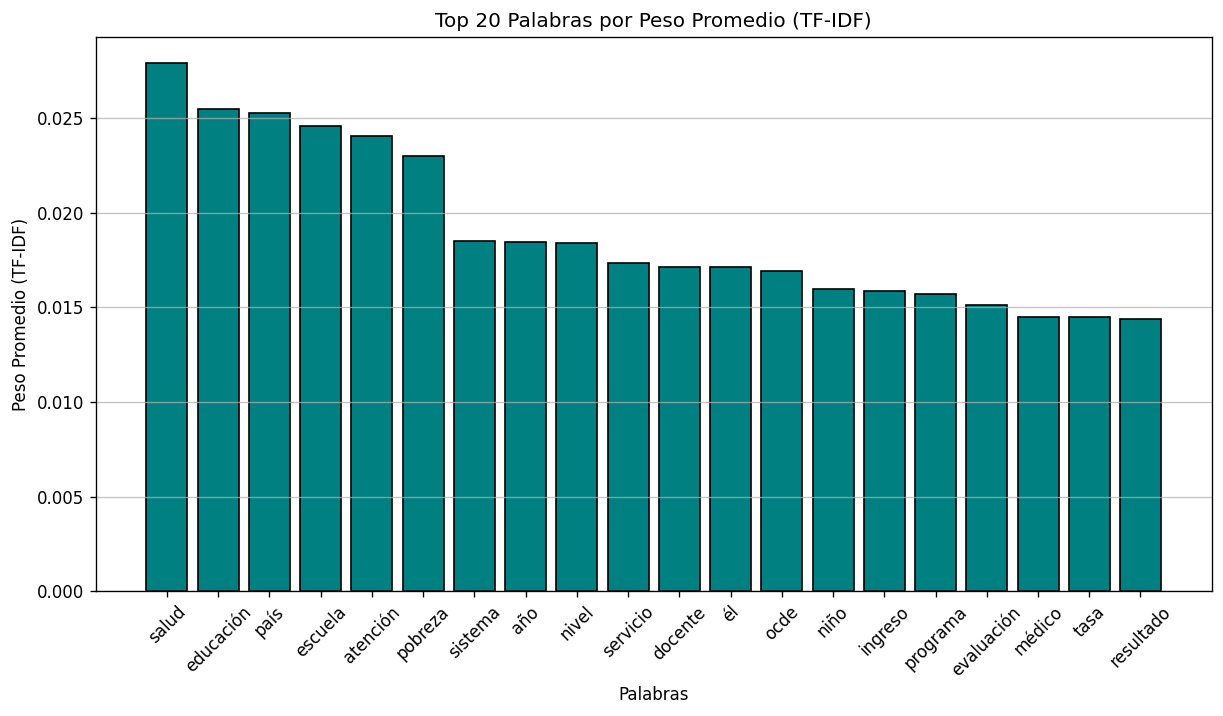

In [150]:
#plot frecuencias
plt.figure(figsize=(12,6))
plt.bar(freq_df['Palabra'][:20], freq_df['Peso Promedio'][:20], color='teal', edgecolor='black')
plt.title('Top 20 Palabras por Peso Promedio (TF-IDF)')
plt.xlabel('Palabras')
plt.ylabel('Peso Promedio (TF-IDF)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

## Modelo Santiago Gomez


Se construyó una red neuronal de una capa oculta con 128 neuronas usando MLPClassifier, diseñada para clasificar los textos según sus etiquetas. El dataset se dividió en tres partes: un 20% se reservó para pruebas, mientras que el 80% restante se utilizó para entrenamiento y validación, separando un 12.5% de este último para validación y asegurando que cada conjunto mantuviera aproximadamente la misma proporción de clases. Los textos fueron transformados en vectores numéricos mediante TF-IDF, con un valor de 1 a 2 n-gramas, para de ese modo poder capturar tanto palabras individuales como conjuntas. La capa oculta usa ReLU como función de activación con el fin de convertir los valores previamente vectorizados en binarios, eliminando proporciones negativas. Mientras que la capa de salida usa Softmax que convierte las puntuaciones en probabilidades que suman 1, permitiendo interpretar la confianza del modelo en cada categoría.


### Softmax

$$
a_1 = \frac{e^{z_1}}{e^{z_1} + e^{z_2} + e^{z_3} + e^{z_4}}
$$

### Busqueda de hiperpatametros

```python
Se realizó una busqueda gridi de los mejores hiperparamtros probando sobre la red neuronal con el siguiente codigo.

pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer()),
    ("mlp", MLPClassifier(random_state=42, early_stopping=True, max_iter=300))
])

param_grid = {
    # TF-IDF
    "tfidf__max_features": [2000, 3000],
    "tfidf__min_df": [1, 2],
    "tfidf__max_df": [0.7, 0.8, 0.9],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    # MLP
    "mlp__hidden_layer_sizes": [(128,), (128, 64), (256, 128)],
    "mlp__activation": ["relu"],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [1e-3, 1e-2],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

Una vez obtenemos los hiperparametros los ubicamos directamente dentro de la red para disminuir el tiempo de ejecución de la misma
```



In [151]:

def redNeuronal(textos, labels):
    XTrain1, XTest, yRestante, yTest = train_test_split(
        textos, labels, test_size=0.20, random_state=42, stratify=labels
    )
    

    XTrain2, XVal, yTrain, yVal = train_test_split(
        XTrain1, yRestante, test_size=0.125, random_state=42, stratify=yRestante
    )
    
    vectorizer = TfidfVectorizer(
        max_features=3000,
        min_df=1,
        max_df=0.8,
        ngram_range=(1, 2)
    )
    XTrain = vectorizer.fit_transform(XTrain2)
    XVal   = vectorizer.transform(XVal)
    XTest  = vectorizer.transform(XTest)

    red = MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        random_state=42,
        alpha=np.float64(0.0005611516415334506),
        learning_rate_init=np.float64(0.0005611516415334506),
        max_iter=300,
        early_stopping=True
    )
    red.fit(XTrain, yTrain)

    yValPred  = red.predict(XVal)
    yValProba = red.predict_proba(XVal)
    yTestPred  = red.predict(XTest)
    yTestProba = red.predict_proba(XTest)

    return (red, vectorizer,
            XTrain, XVal, XTest,
            yTrain, yVal, yTest,
            yValPred, yValProba, yTestPred, yTestProba)

textos = [" ".join(t) for t in df['lematizados']]

(red, vectorizer,
 XTrain, XVal, XTest,
 yTrain, yVal, yTest,
 yValPred, yValProba, yTestPred, yTestProba) = redNeuronal(textos, df['labels'])



### Muestra de resultados

Para evaluar el desempeño del modelo, se implementó un análisis de métricas clave tanto en los conjuntos de validación como de prueba. Se calculó la exactitud, que indica qué porcentaje de predicciones fueron correctas, y el ROC AUC, que mide la capacidad del modelo para distinguir entre clases, adaptándose automáticamente a problemas binarios o multiclase. Además, se generó un reporte de clasificación que incluye precisión, recall y F1-score por categoría, proporcionando un panorama completo de cómo se comporta el modelo en cada clase.

In [152]:

def imprimir_metricas_simple(yTrue, yPred, yProba):
    acc = accuracy_score(yTrue, yPred)
    if yProba.shape[1] == 2:
        roc = roc_auc_score(yTrue, yProba[:, 1])
        roc_txt = f"ROC AUC: {roc:.4f}"
    else:
        roc = roc_auc_score(yTrue, yProba, multi_class="ovr", average="macro")
        roc_txt = f"ROC AUC: {roc:.4f}"

    print(f"Accuracy: {acc:.4f}\n{roc_txt}\n")
    print(classification_report(yTrue, yPred, digits=4))

print("===================== Resultados en Validación =====================")
imprimir_metricas_simple(yVal, yValPred, yValProba)
print("===================== Resultados en Test =====================")
imprimir_metricas_simple(yTest, yTestPred, yTestProba)

===================== Resultados en Validación =====================
Accuracy: 0.9588
ROC AUC: 0.9980

              precision    recall  f1-score   support

           1     0.9423    0.9608    0.9515        51
           3     0.9663    0.9663    0.9663        89
           4     0.9608    0.9515    0.9561       103

    accuracy                         0.9588       243
   macro avg     0.9565    0.9595    0.9579       243
weighted avg     0.9589    0.9588    0.9589       243

===================== Resultados en Test =====================
Accuracy: 0.9464
ROC AUC: 0.9948

              precision    recall  f1-score   support

           1     0.9216    0.9307    0.9261       101
           3     0.9598    0.9330    0.9462       179
           4     0.9474    0.9659    0.9565       205

    accuracy                         0.9464       485
   macro avg     0.9429    0.9432    0.9429       485
weighted avg     0.9466    0.9464    0.9464       485



Para complementar la evaluación del modelo, se generó una matriz de confusión del conjunto de prueba. Este gráfico muestra cómo se distribuyen las predicciones frente a las etiquetas reales, permitiendo identificar qué clases se predicen correctamente y cuáles se confunden entre sí.

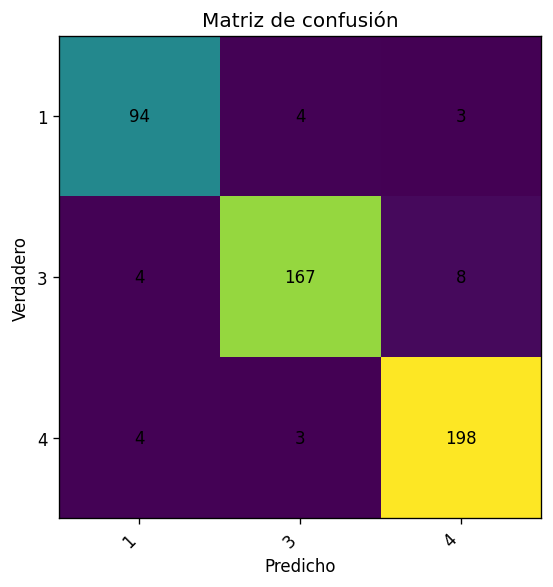

In [153]:
def plot_confusion(yTrue, yPred, classes):
    cm = confusion_matrix(yTrue, yPred, labels=classes)
    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión")
    plt.xticks(np.arange(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(np.arange(len(classes)), classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.tight_layout()
    plt.show()

plot_confusion(yTest, yTestPred, red.classes_)

Para evaluar la capacidad del modelo de distinguir entre clases, se generaron las curvas ROC multiclase.

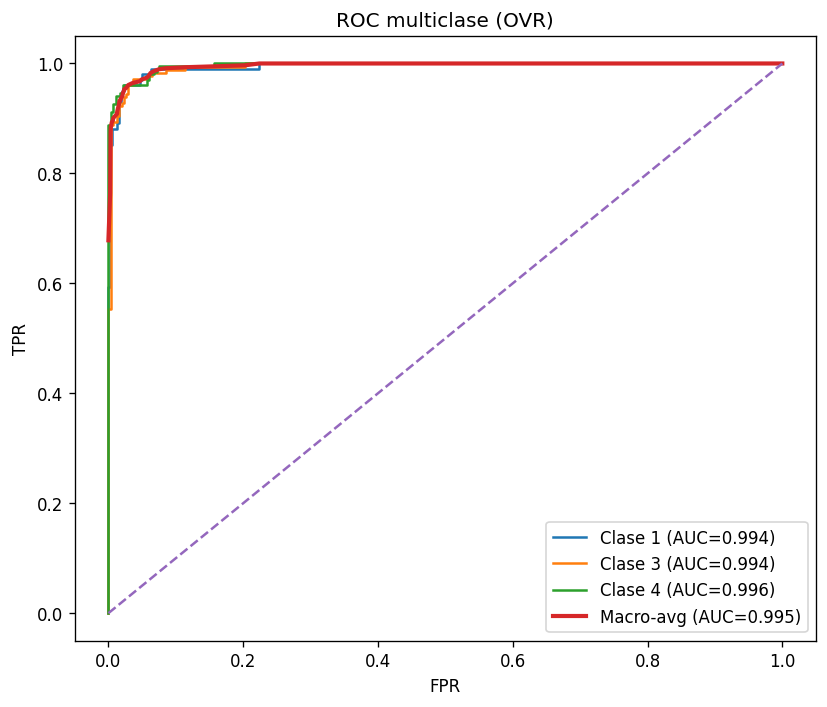

In [154]:
def plotRocCurves(yTrue, yProba, clases):
    clases = np.array(list(clases))
    nClases = len(clases)

    yTrueB = label_binarize(yTrue, classes=clases)
    fprDict, tprDict, aucDict = {}, {}, {}

    for i, c in enumerate(clases):
        fprDict[i], tprDict[i], _ = roc_curve(yTrueB[:, i], yProba[:, i])
        aucDict[i] = auc(fprDict[i], tprDict[i])

    allFpr = np.unique(np.concatenate([fprDict[i] for i in range(nClases)]))
    meanTpr = np.zeros_like(allFpr)
    for i in range(nClases):
        meanTpr += np.interp(allFpr, fprDict[i], tprDict[i])
    meanTpr /= nClases
    macroAuc = auc(allFpr, meanTpr)

    fig = plt.figure(figsize=(7, 6))
    for i, c in enumerate(clases):
        plt.plot(fprDict[i], tprDict[i], label=f"Clase {c} (AUC={aucDict[i]:.3f})")
    plt.plot(allFpr, meanTpr, linewidth=2.5, label=f"Macro-avg (AUC={macroAuc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("ROC multiclase (OVR)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plotRocCurves(yTest, yTestProba, red.classes_)


Por ultimo, para entender qué palabras son más representativas de cada clase, se realizó un análisis de importancia de términos usando la prueba chi-cuadrado sobre el conjunto de entrenamiento. Para cada categoría, se comparó la presencia de cada palabra con la pertenencia a la clase, calculando un puntaje que indica qué tan informativa es esa palabra para diferenciarla de las demás.

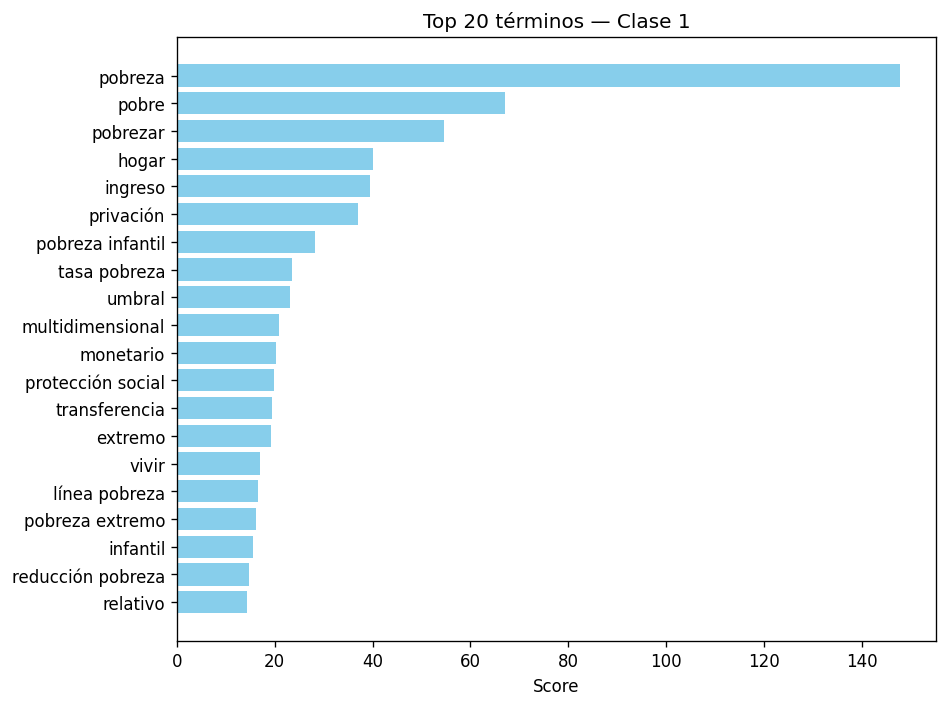

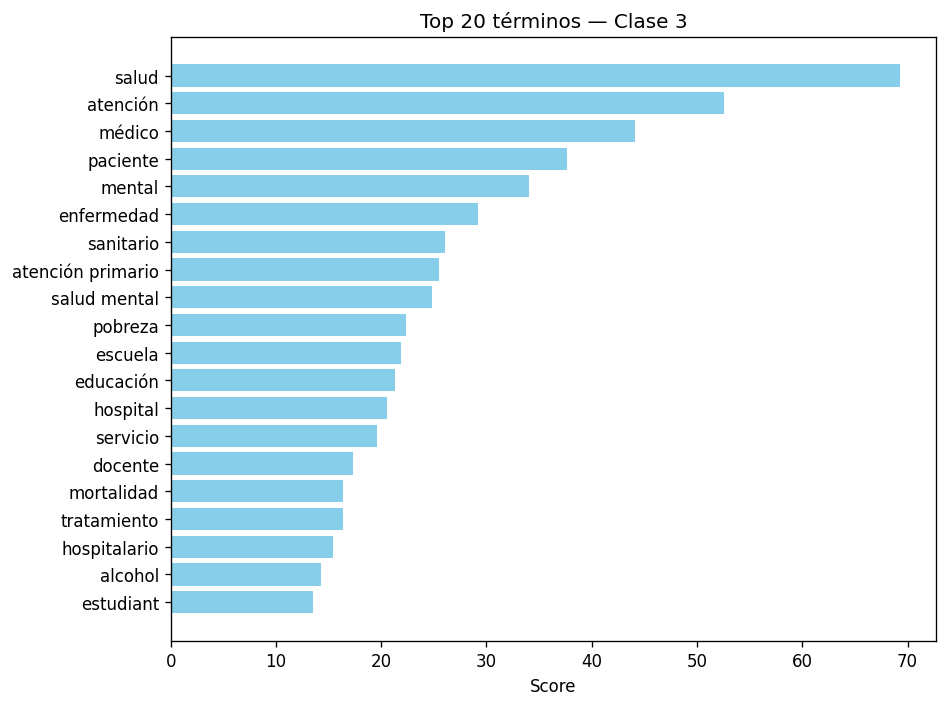

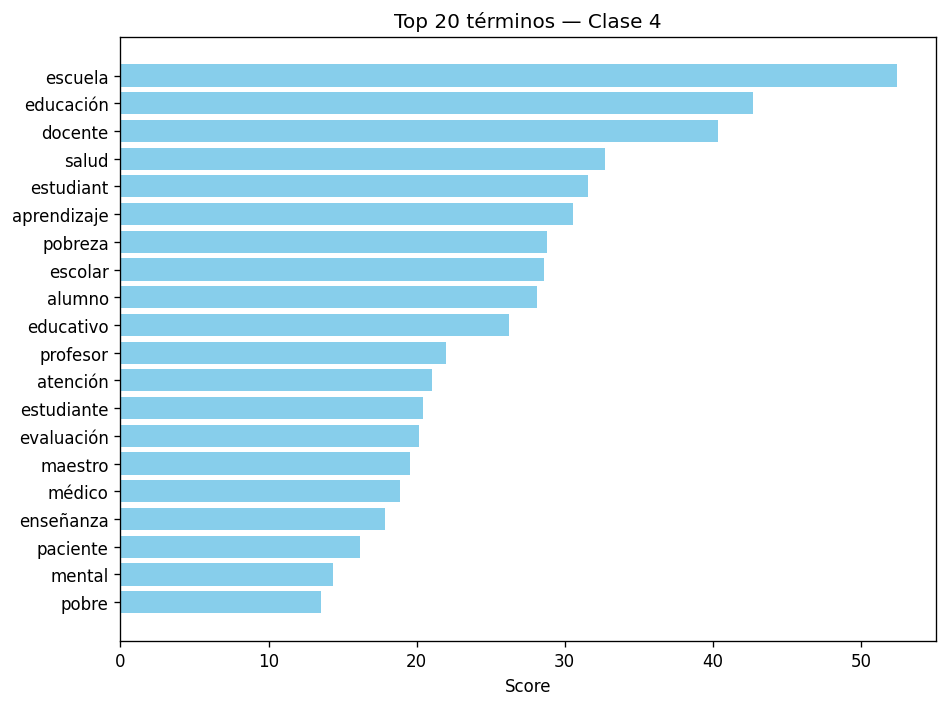

In [155]:
def plotTopTermsChi2(XTrain, yTrain, vectorizer, clases, k=20):
    featNames = np.array(vectorizer.get_feature_names_out())
    clases = np.array(list(clases))

    for c in clases:
        yBin = (yTrain == c).astype(int)
        scores, _ = chi2(XTrain, yBin)
        
        orden = np.argsort(scores)[::-1]
        ordenValid = [idx for idx in orden if np.isfinite(scores[idx])]
        topIdx = ordenValid[:k]

        topTerms = featNames[topIdx]
        topScores = scores[topIdx]

        plt.figure(figsize=(8, 6))
        plt.barh(range(len(topTerms)), topScores, color="skyblue")
        plt.yticks(range(len(topTerms)), topTerms)
        plt.gca().invert_yaxis()  
        plt.title(f"Top {k} términos — Clase {c}")
        plt.xlabel("Score")
        plt.tight_layout()
        plt.show()

plotTopTermsChi2(XTrain, yTrain, vectorizer, red.classes_, k=20)

## Modelo Sebastian Martinez

Ahora despues de haber analizado los datos y hacer el proceso para mejorar la calidad de estos, empezaremos a hacer el modelo, en este caso haremos uso del algoritmo KNN (K-Nearest Neighbors) para poder clasificar nuestros datos. Primero hacemos los import necesarios y despues tenemos que saber que para hacer el analisis es necesario unir los tokens lematizados en un solo string por fila, ya que no se puede analizar uno por uno, sino que se analizan todas las palabras juntas

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

df['lematizados_str'] = df['lematizados'].apply(lambda tokens: ' '.join(tokens))
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados,lematizados_str
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ...",aprendizaje educación considerar sinónir escol...
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac...",niño pequeño bebé niño pequeño capacitación es...
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in...",formación especialista medicín general incluir...
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio...",país ocde tender pasar curso obligatorio optat...
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ...",grupo centrar persona padecer trastorno mental...


Asignamos un 20% del dataset para que sea analizado como parte de pruebasm mientras que el 80% se designara netamente en el entrenamiento del modelo con el algoritmo KNN

In [157]:
X_train_Seb, X_test_Seb, y_train_Seb, y_test_Seb = train_test_split(df['lematizados_str'], df['labels'], test_size=0.20, random_state=42, stratify=df['labels'])

X_train_Seb.shape, X_test_Seb.shape

((1939,), (485,))

Ahora se crea una función que entrena el modelo, imprime unas metricas, siendo la precisión y el ROC AUC del modelo, muestra un reporte de la clasificación con el f1-score, facilitando la evaluación del KNN.

In [158]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


def evaluar_knn(pipeline, X_train, y_train, X_test, y_test, titulo="KNN"):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    y_proba = None
    try:
        y_proba = pipeline.predict_proba(X_test)
    except Exception:
        pass

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {titulo} ===")
    print("Accuracy (test):", round(acc, 4))

    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

    print("ROC AUC (test):", round(auc, 4))


    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in sorted(set(y_test))]))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test)))
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, colorbar=False)
    plt.title(f"Matriz de confusión — {titulo}")
    plt.show()

    # Curvas ROC solo si quieres verlas en multiclase
    if y_proba is not None and len(set(y_test)) == 2:
        RocCurveDisplay.from_predictions(y_test, y_proba[:,1])
        plt.title(f"Curva ROC — {titulo}")
        plt.show()

Se define el pipeline con TfidfVectorizer para que transforme la columna de lematizados a numeros para poder hacer el analisis bien, se define el knn para el modelo y asi evaluar su rendimiento.


=== KNN ===
Accuracy (test): 0.9546
ROC AUC (test): 0.9929

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       101
           3       0.96      0.96      0.96       179
           4       0.97      0.95      0.96       205

    accuracy                           0.95       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.96      0.95      0.95       485



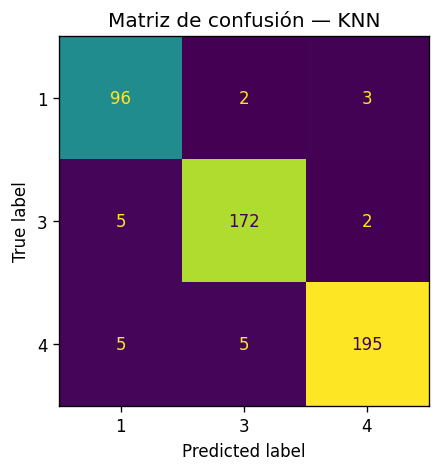

In [159]:
pipe_knn = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("knn", KNeighborsClassifier())
])

evaluar_knn(pipe_knn, X_train_Seb, y_train_Seb, X_test_Seb, y_test_Seb, titulo="KNN")

Aca experimentamos con diferentes distancias para identificar cual de estas se adapta mejor al modelo planteado


=== KNN Distancia Euclídea (p=2) ===
Accuracy (test): 0.9546
ROC AUC (test): 0.9929

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       101
           3       0.96      0.96      0.96       179
           4       0.97      0.95      0.96       205

    accuracy                           0.95       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.96      0.95      0.95       485



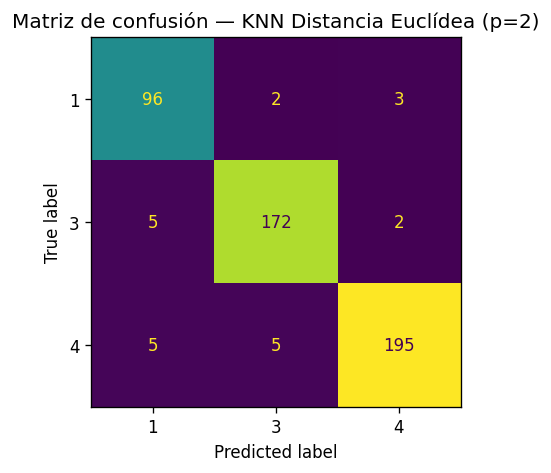


=== KNN Distancia Manhattan (p=1) ===
Accuracy (test): 0.5897
ROC AUC (test): 0.7357

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.88      0.14      0.24       101
           3       0.74      0.45      0.56       179
           4       0.53      0.93      0.68       205

    accuracy                           0.59       485
   macro avg       0.71      0.51      0.49       485
weighted avg       0.68      0.59      0.54       485



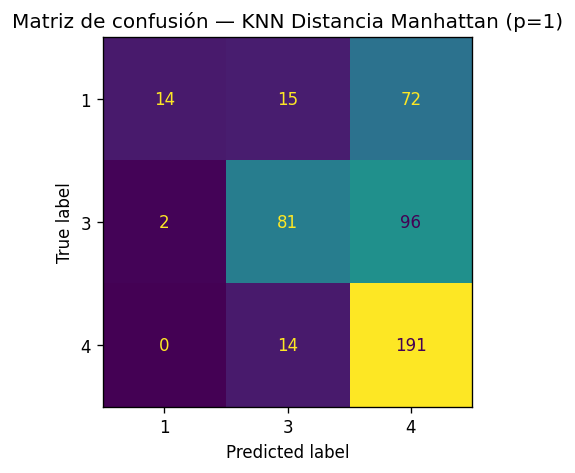


=== KNN Distancia Coseno ===
Accuracy (test): 0.9546
ROC AUC (test): 0.9929

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       101
           3       0.96      0.96      0.96       179
           4       0.97      0.95      0.96       205

    accuracy                           0.95       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.96      0.95      0.95       485



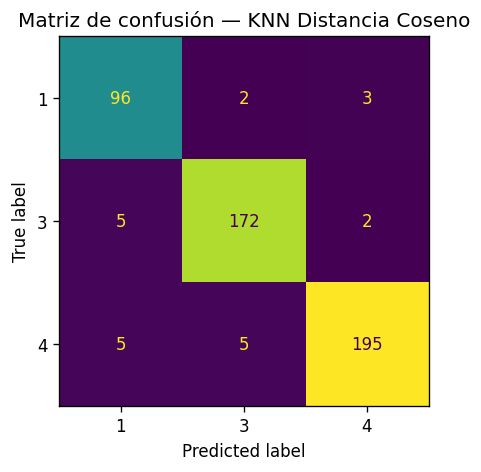

In [160]:
pipe_euclid = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(metric="minkowski", p=2))])

pipe_manhat = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(metric="minkowski", p=1))])

pipe_cosine = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(metric="cosine"))])


evaluar_knn(pipe_euclid, X_train_Seb, y_train_Seb, X_test_Seb, y_test_Seb, titulo="KNN Distancia Euclídea (p=2)")
evaluar_knn(pipe_manhat, X_train_Seb, y_train_Seb, X_test_Seb, y_test_Seb, titulo="KNN Distancia Manhattan (p=1)")
evaluar_knn(pipe_cosine, X_train_Seb, y_train_Seb, X_test_Seb, y_test_Seb, titulo="KNN Distancia Coseno")

Se fija el valor de los n vecinos mas cercanos como 13, siendo este el mejor valor encontrado tras varias pruebas que no se presentan dentro de este archivo.


=== KNN k=13 (mejor modelo encontrado) ===
Accuracy (test): 0.9608
ROC AUC (test): 0.9959

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       101
           3       0.96      0.96      0.96       179
           4       0.98      0.97      0.97       205

    accuracy                           0.96       485
   macro avg       0.95      0.96      0.96       485
weighted avg       0.96      0.96      0.96       485



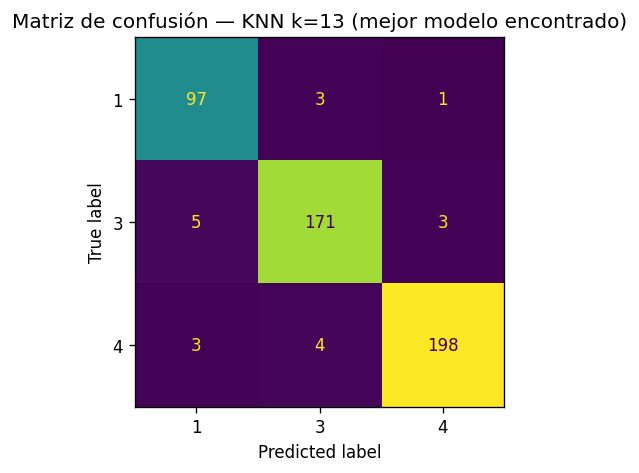

In [161]:
best_pipe = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(n_neighbors=13))])
evaluar_knn(best_pipe, X_train_Seb, y_train_Seb, X_test_Seb, y_test_Seb, titulo="KNN k=13 (mejor modelo encontrado)")

Finalmente usamos GridSearchCV para encontrar los mejores hiperparámetros del modelo KNN, seleccionarlos y dar el mejor modelo.

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor score de CV (train): 0.9598

=== Mejor modelo (GridSearch) ===
Accuracy (test): 0.9567
ROC AUC (test): 0.996

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.93      0.95      0.94       101
           3       0.97      0.95      0.96       179
           4       0.96      0.97      0.96       205

    accuracy                           0.96       485
   macro avg       0.95      0.96      0.95       485
weighted avg       0.96      0.96      0.96       485



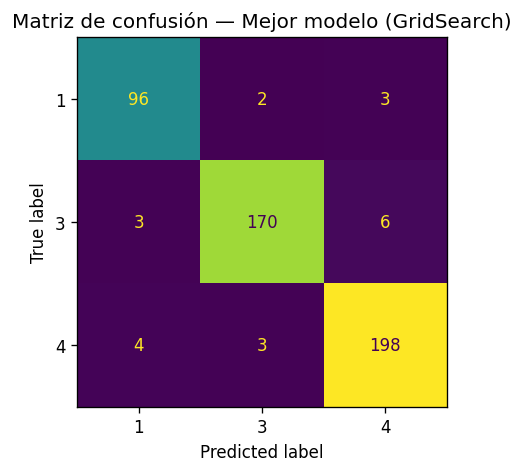

In [162]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 13, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2], 
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy", 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid.fit(X_train_Seb, y_train_Seb)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score de CV (train):", round(grid.best_score_, 4))

best_knn = grid.best_estimator_
evaluar_knn(best_knn, X_train_Seb, y_train_Seb, X_test_Seb, y_test_Seb, titulo="Mejor modelo (GridSearch)")

## Modelo Johan Suarez

Se construyó y evaluó el 3er modelo para clasificar las opiniones de la ciudadanía en función de los ODS 1, 3 y 4. Se eligió un SVM lineal (LinearSVC) junto con un vectorizador TF-IDF de
uni-gramas y bi-gramas. Esto porque el vectorizador permite representar los textos de forma numérica considerando no solo la frecuencia de cada término, sino su importancia,
dando más peso a palabras informativas y menos a palabras muy frecuentes. Además, SVM lineal es adecuado para clasificación de texto en alta dimensión.

### Preparación de datos

En este paso unimos los tokens lematizados de cada documento en un solo string,
extraemos las etiquetas y realizamos el split en entrenamiento y prueba (80/20).


In [163]:
plt.rcParams["figure.dpi"] = 120

def nombre_clase(c):
    try:
        return targetNames.get(c, str(c))
    except Exception:
        return str(c)

textos = [" ".join(t) for t in df["lematizados"]]
labels = df["labels"].values
classes_sorted = np.sort(np.unique(labels))
classes_names  = [nombre_clase(c) for c in classes_sorted]

X_train_J, X_test_J, y_train_J, y_test_J = train_test_split(
    textos, labels, test_size=0.2, random_state=42, stratify=labels
)

### Vectorización TF-IDF

Se convierte cada texto en un vector TF-IDF usando uni-gramas y bi-gramas, eliminando términos demasiado raros o demasiado frecuentes.

In [164]:
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    analyzer="word",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    max_features=8000
)
Xtr = tfidf.fit_transform(X_train_J)
Xte = tfidf.transform(X_test_J)

### Entrenamiento del modelo SVM lineal

Se entrena un LinearSVC buscando el mejor hiperparámetro `C` mediante
validación cruzada estratificada y optimizando la métrica F1-macro.


In [165]:
from sklearn.calibration import LinearSVC


base = LinearSVC(class_weight="balanced", random_state=42)
param_grid = {"C": [0.1, 0.5, 1, 2, 5, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(base, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1)
grid.fit(Xtr, y_train_J)
clf = grid.best_estimator_

print(f"Mejor C: {grid.best_params_['C']} | F1-macro (CV): {grid.best_score_:.4f}")

Mejor C: 1 | F1-macro (CV): 0.9755


### Métricas de evaluación
Se reportan:
- Accuracy 
- Precision, Recall y F1-score por clase (train y test)  
- F1-macro y micro para el balance general  
- Matriz de confusión
- F1 por clase (gráfico de barras)
- Curva ROC y AUC (micro-average en caso multiclase)  

Además, se muestran los Top 15 términos más relevantes por clase para
interpretar el modelo, y se genera un CSV con los resultados del conjunto de prueba
incluyendo las predicciones y los scores de decisión.


=== Reporte de Clasificación (TRAIN) ===
              precision    recall  f1-score   support

       ODS 1       1.00      1.00      1.00       404
       ODS 3       1.00      1.00      1.00       715
       ODS 4       1.00      1.00      1.00       820

    accuracy                           1.00      1939
   macro avg       1.00      1.00      1.00      1939
weighted avg       1.00      1.00      1.00      1939



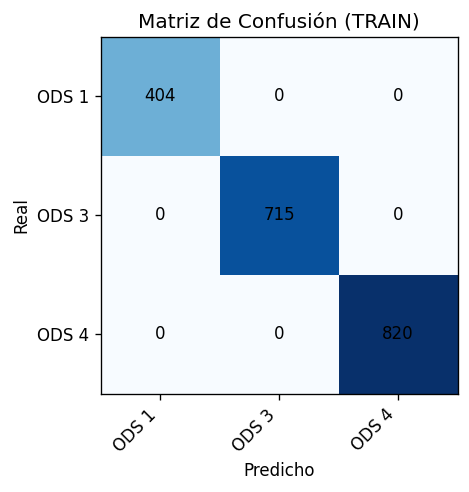


=== Reporte de Clasificación (TEST) ===
              precision    recall  f1-score   support

       ODS 1       0.96      0.94      0.95       101
       ODS 3       0.96      0.98      0.97       179
       ODS 4       0.99      0.98      0.98       205

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



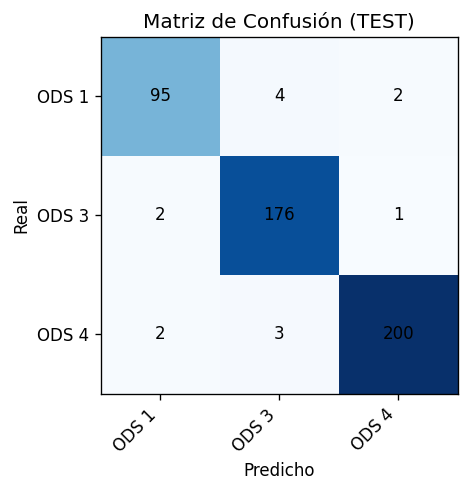

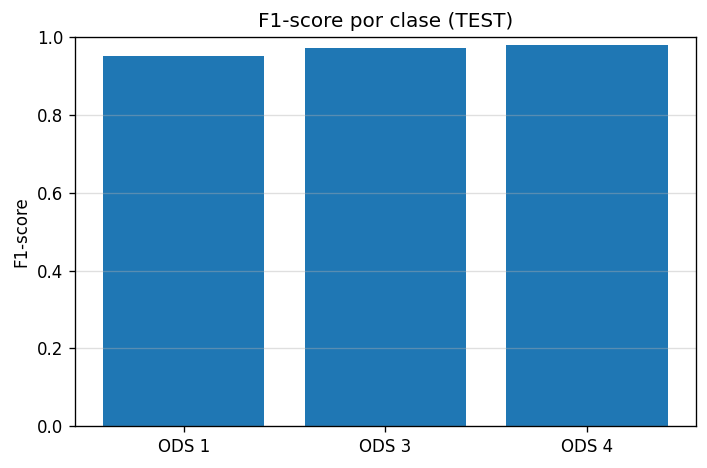

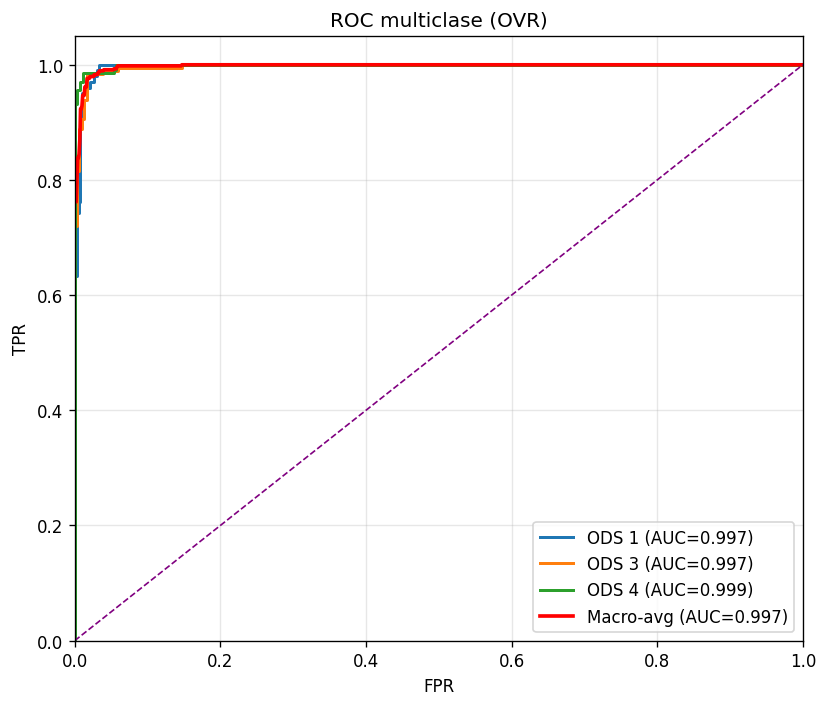


Top 15 términos para ODS 1


,clase,termino,peso
0,ODS 1,pobreza,4.702411
1,ODS 1,pobre,2.709210
2,ODS 1,pobrezar,2.378649
3,ODS 1,hogar,1.592232
4,ODS 1,ingreso,1.525329
5,ODS 1,privacion,1.495633
6,ODS 1,proteccion social,1.475519
7,ODS 1,social,1.247439
8,ODS 1,proteccion,1.181574
9,ODS 1,empleo,1.175234


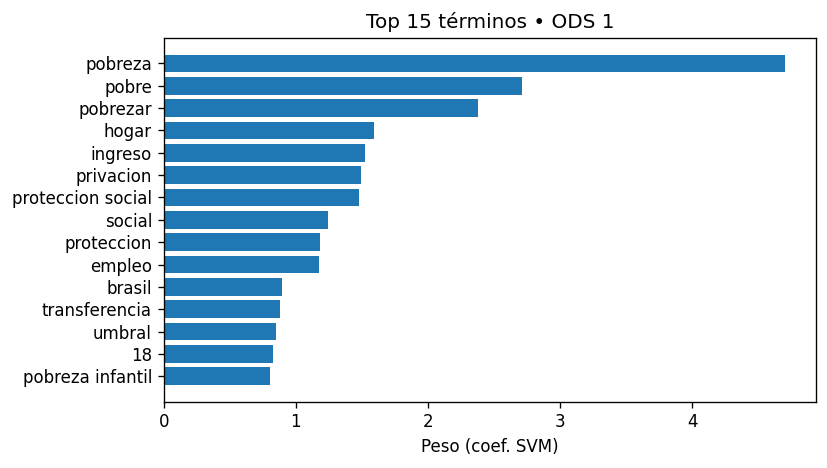


Top 15 términos para ODS 3


,clase,termino,peso
0,ODS 3,salud,3.881389
1,ODS 3,medico,2.233747
2,ODS 3,atencion,1.865589
3,ODS 3,sanitario,1.861848
4,ODS 3,enfermedad,1.859288
5,ODS 3,paciente,1.815226
6,ODS 3,mental,1.269323
7,ODS 3,hospital,1.266145
8,ODS 3,alcohol,1.240456
9,ODS 3,mortalidad,1.226056


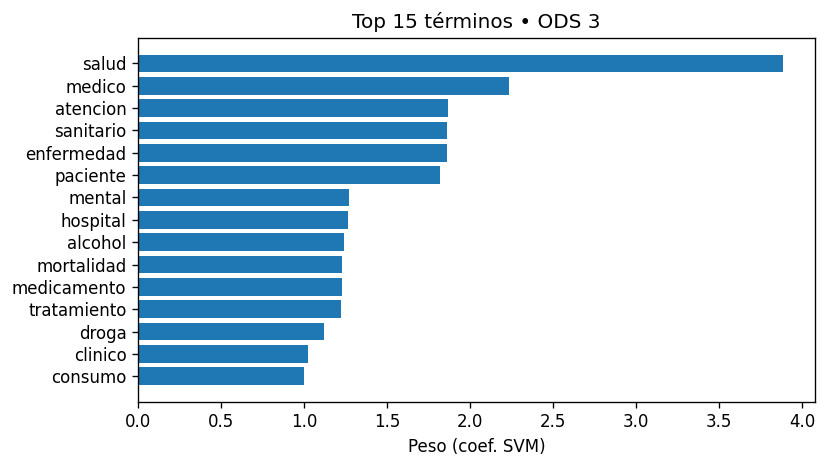


Top 15 términos para ODS 4


,clase,termino,peso
0,ODS 4,educacion,3.123979
1,ODS 4,escuela,2.748537
2,ODS 4,educativo,2.261743
3,ODS 4,estudiant,1.858124
4,ODS 4,docente,1.820946
5,ODS 4,aprendizaje,1.689402
6,ODS 4,escolar,1.674614
7,ODS 4,alumno,1.587900
8,ODS 4,profesor,1.472845
9,ODS 4,maestro,1.274232


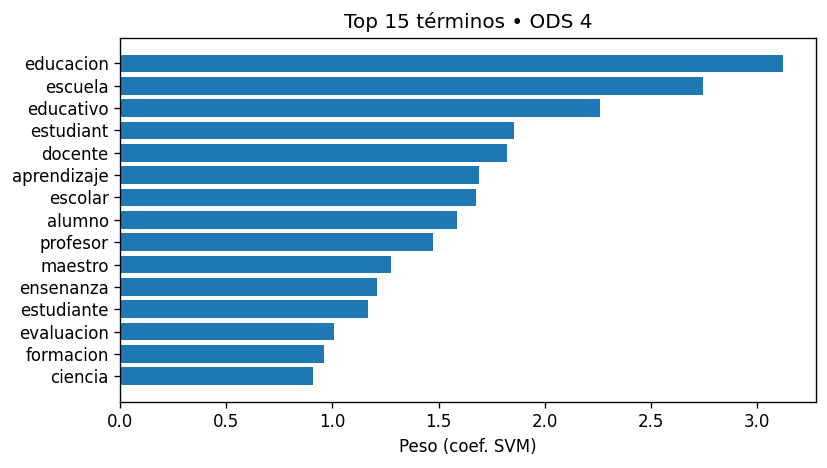

In [166]:
from sklearn.metrics import precision_recall_fscore_support


y_pred_train = clf.predict(Xtr)
y_pred_test  = clf.predict(Xte)

print("\n=== Reporte de Clasificación (TRAIN) ===")
print(classification_report(y_train_J, y_pred_train, target_names=classes_names))
cm_train = confusion_matrix(y_train_J, y_pred_train, labels=classes_sorted)
fig, ax = plt.subplots(figsize=(5.6, 4.2))
im = ax.imshow(cm_train, cmap="Blues")
ax.set_title("Matriz de Confusión (TRAIN)")
ax.set_xticks(range(len(classes_sorted))); ax.set_yticks(range(len(classes_sorted)))
ax.set_xticklabels(classes_names, rotation=45, ha="right"); ax.set_yticklabels(classes_names)
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        ax.text(j, i, cm_train[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout(); plt.show()

print("\n=== Reporte de Clasificación (TEST) ===")
print(classification_report(y_test_J, y_pred_test, target_names=classes_names))
cm_test = confusion_matrix(y_test_J, y_pred_test, labels=classes_sorted)
fig, ax = plt.subplots(figsize=(5.6, 4.2))
im = ax.imshow(cm_test, cmap="Blues")
ax.set_title("Matriz de Confusión (TEST)")
ax.set_xticks(range(len(classes_sorted))); ax.set_yticks(range(len(classes_sorted)))
ax.set_xticklabels(classes_names, rotation=45, ha="right"); ax.set_yticklabels(classes_names)
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, cm_test[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout(); plt.show()

_, _, f1_por_clase, _ = precision_recall_fscore_support(y_test_J, y_pred_test, labels=classes_sorted)
plt.figure(figsize=(6,4))
plt.bar(classes_names, f1_por_clase)
plt.title("F1-score por clase (TEST)")
plt.ylabel("F1-score"); plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.4)
plt.tight_layout(); plt.show()

y_test_bin = label_binarize(y_test_J, classes=classes_sorted)
scores = clf.decision_function(Xte)

if scores.ndim == 1:
    scores = scores.reshape(-1, 1)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes_sorted)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0, 1, 1000)
mean_tpr = np.zeros_like(fpr_grid)
for i in range(len(classes_sorted)):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
mean_tpr /= len(classes_sorted)
roc_auc["macro"] = auc(fpr_grid, mean_tpr)

plt.figure(figsize=(7,6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"] 
for i, cls_name in enumerate(classes_names):
    plt.plot(fpr[i], tpr[i], lw=1.8, label=f"{cls_name} (AUC={roc_auc[i]:.3f})", color=colors[i])
plt.plot(fpr_grid, mean_tpr, color="red", lw=2.2, label=f"Macro-avg (AUC={roc_auc['macro']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="purple", lw=1)

plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC multiclase (OVR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_
top_k = 15
tops_frames = []
for pos, cls in enumerate(clf.classes_):
    idx = np.argsort(coefs[pos])[::-1][:top_k]
    df_top = pd.DataFrame({
        "clase": nombre_clase(cls),
        "termino": feature_names[idx],
        "peso": coefs[pos][idx]
    })
    tops_frames.append(df_top)
    print(f"\nTop {top_k} términos para {nombre_clase(cls)}")
    display(df_top)
    plt.figure(figsize=(7,4))
    plt.barh(df_top["termino"][::-1], df_top["peso"][::-1])
    plt.title(f"Top {top_k} términos • {nombre_clase(cls)}")
    plt.xlabel("Peso (coef. SVM)")
    plt.tight_layout(); plt.show()



## Carga de datos test

In [167]:
def cargar_datos(file: str):
    df_prueba = pd.read_excel(file)
    df_prueba = df_prueba.rename(columns={"Textos_espanol": "textos"})
    df_prueba['textos'] = df_prueba['textos'].astype("string")
    todoAmin(df_prueba)
    limpiza(df_prueba)
    verNulosYDuplicados(df_prueba)
    df_prueba = tokenizacion(df_prueba)   
    quitar_stopwords(df_prueba)
    df_prueba =lematizar_tokens(df_prueba)


    df_prueba = lematizar_tokens(df_prueba)
    df_prueba['lematizados_str'] = df_prueba['lematizados'].apply(lambda tokens: ' '.join(tokens))
    return df_prueba

test = cargar_datos('Datos de prueba_proyecto.xlsx')
test.head()

Valores nulos por columna:


textos    0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


,textos,tokens,tokens_sin_innecesarios,lematizados,lematizados_str
0,el rector que es el representante local del mi...,"[el, rector, que, es, el, representante, local...","[rector, representante, local, ministerio, edu...","[rector, representante, local, ministerio, edu...",rector representante local ministerio educació...
1,tenga en cuenta que todos los programas antipo...,"[tenga, en, cuenta, que, todos, los, programas...","[programas, antipobreza, condiciones, caracter...","[programa, antipobrezar, condición, caracteriz...",programa antipobrezar condición caracterizado ...
2,debido a que son en gran medida invisibles est...,"[debido, a, que, son, en, gran, medida, invisi...","[medida, invisibles, formas, trabajo, infantil...","[medida, invisible, forma, trabajo, infantil, ...",medida invisible forma trabajo infantil difíci...
3,los recursos aún son limitados en este sector ...,"[los, recursos, aún, son, limitados, en, este,...","[recursos, limitados, sector, servicios, priva...","[recurso, limitado, sector, servicio, privado,...",recurso limitado sector servicio privado fin l...
4,durante el período 1985-2008 la educación prim...,"[durante, el, período, 1985-2008, la, educació...","[período, 1985-2008, educación, primaria, secu...","[período, 1985-2008, educación, primario, secu...",período 1985-2008 educación primario secundari...


In [168]:
assert "lematizados_str" in test.columns, "Falta la columna 'lematizados_str' en test"

df_pred = test.copy()
textos_prueba = test["lematizados_str"].astype(str)

try:
    y_knn = best_knn.predict(textos_prueba)
    df_pred["pred_KNN"] = y_knn
except Exception as e:
    print(" No se pudo predecir con KNN (best_knn):", e)

try:
    X_red = vectorizer.transform(textos_prueba)
    y_red = red.predict(X_red)
    df_pred["pred_RedNeuronal"] = y_red
except Exception as e:
    print(" No se pudo predecir con la Red Neuronal:", e)

try:
    X_svm = tfidf.transform(textos_prueba)
    y_svm = clf.predict(X_svm)
    df_pred["pred_SVM"] = y_svm
except Exception as e:
    print(" No se pudo predecir con SVM:", e)

try:
    if "pred_SVM" in df_pred:
        df_pred["pred_SVM_ODS"] = [targetNames.get(x, str(x)) for x in df_pred["pred_SVM"]]
    if "pred_KNN" in df_pred:
        df_pred["pred_KNN_ODS"] = [targetNames.get(x, str(x)) for x in df_pred["pred_KNN"]]
    if "pred_RedNeuronal" in df_pred:
        df_pred["pred_RedNeuronal_ODS"] = [targetNames.get(x, str(x)) for x in df_pred["pred_RedNeuronal"]]
except Exception:
    pass

excel_out = "Datos_de_prueba_PREDICCIONES_3_MODELOS.xlsx"
csv_out   = "Datos_de_prueba_PREDICCIONES_3_MODELOS.csv"

df_pred.to_excel(excel_out, index=False)
df_pred.to_csv(csv_out, index=False, encoding="utf-8")

print("Archivos guardados:")
print(" -", excel_out)
print(" -", csv_out)

Archivos guardados:
 - Datos_de_prueba_PREDICCIONES_3_MODELOS.xlsx
 - Datos_de_prueba_PREDICCIONES_3_MODELOS.csv


## Selección de modelo

Al comparar los tres modelos entrenados (Red Neuronal, KNN y SVM) se observa que cada uno presenta fortalezas particulares. La Red Neuronal (MLP) ofrece un rendimiento sólido, con un accuracy en prueba de 0.946 y un ROC AUC cercano a 0.998, lo que refleja una excelente capacidad para discriminar entre clases y, además, permite obtener probabilidades bien calibradas que resultan útiles en escenarios donde se requiere medir la confianza de las predicciones. El KNN, con k=21, alcanza un accuracy de 0.957 y un ROC AUC de 0.996, mostrando un buen equilibrio entre simplicidad e interpretabilidad, aunque presenta limitaciones en escalabilidad y velocidad al trabajar con grandes volúmenes de datos. Por su parte, el SVM (LinearSVC) logra el mejor desempeño global, con un accuracy y un F1-macro en prueba de aproximadamente 0.97, confirmando que los datos vectorizados mediante TF-IDF se ajustan bien a un modelo lineal, aunque con la desventaja de no proporcionar probabilidades directamente. En conclusión, aunque los tres algoritmos son válidos, el modelo más conveniente es el SVM, ya que combina la mayor precisión y robustez en clasificación, convirtiéndose en la opción más adecuada para este problema; sin embargo, vale la pena destacar que la Red Neuronal puede ser preferible en escenarios donde se requieran probabilidades explícitas y que KNN es útil cuando se prioriza la interpretabilidad.